In [145]:
import re
import os
import numpy as np
from proscript import *
import sentencepiece as spm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import ast
from collections import Counter
from dataclasses import dataclass

In [2]:
#LOAD PIECING MODEL
sp = spm.SentencePieceProcessor()
sp.Load("/Users/alp/Documents/Corpora/ted_en-es/sentencepieced/ted.model")

True

In [3]:
translation_data_file = "onmt-heroes/heroes.translation.out"
proscript_data_file = "/Users/alp/Movies/heroes/transProse_data/audiodata-post/heroes_corpus_Vpost_audiodata.txt"

In [4]:
def get_proscript_transcript(input_proscript):
    input_tokens = []

    for i, w in enumerate(input_proscript.word_list):
        input_tokens.append(w.punctuation_before + w.word + w.punctuation_after)

    return ' '.join(input_tokens)

In [5]:
#PARSE PROSCRIPT DATA FILE (File with paths to segment proscripts)
all_available_proscript_path = []
with open(proscript_data_file, 'r') as f:
    for l in f:
        en_csv_path = l.split()[3]
        all_available_proscript_path.append(en_csv_path)

In [7]:
#PARSE TRANSLATION INFORMATION [of all sentences] WITH ATTENTION WEIGHTS
#Also does a proof check as some samples from the dataset have minor problems
all_input_pieces = []
all_pred_pieces = []
all_attention_weights = []
all_attention_binary = []
all_proscript = []
all_proscript_path = []

with open(translation_data_file, 'r') as f:
    sent_index = 0
    attention_first_line = True
    for l in f:
        if l.isspace():
            continue
        elif l.startswith(("GOLD", "PRED SCORE")):
            continue
        elif l.startswith("SENT"):
            input_pieces = ast.literal_eval(l[l.find(':') + 2:])
            continue
        elif l.startswith("PRED"):
            pred_pieces = l[l.find(':') + 2:].split()
            continue

        if attention_first_line:
            attention_first_line = False
            num_input_pieces = len(input_pieces)
            num_pred_pieces = len(pred_pieces)
            sent_attention_weights = np.empty([0, num_input_pieces])
            sent_attention_binary = np.empty([0, num_input_pieces])
            continue
            
        #take the rest to the attention matrices until EOS is seen
        try:
            weights = [float(w) if not w.startswith('*') else float(w[1:]) for w in l.split()[1:]]
            binary = [1 if w.startswith('*') else 0 for w in l.split()[1:]]
        except:
            print(l)
            break
        
        if not l.split()[0] == "</s>":
            sent_attention_weights = np.vstack([sent_attention_weights, weights])
            sent_attention_binary = np.vstack([sent_attention_binary, binary])
        else:
            #read corresponding proscript
            input_proscript = Proscript()
            input_proscript.from_file(all_available_proscript_path[sent_index])

            #make sure it matches with proscript info
            proscript_transcript = get_proscript_transcript(input_proscript)
            subtitle_transcript = sp.decode_pieces(input_pieces)
            
            if proscript_transcript == subtitle_transcript:
                #store information 
                all_proscript_path.append(all_available_proscript_path[sent_index])
                all_proscript.append(input_proscript)
                all_input_pieces.append(input_pieces)
                all_pred_pieces.append(pred_pieces)
                all_attention_weights.append(sent_attention_weights)
                all_attention_binary.append(sent_attention_binary)
            attention_first_line = True
            sent_index += 1

In [111]:
inde = 29
print(all_input_pieces[inde])
subtitle_transcript = sp.decode_pieces(all_input_pieces[inde])
print('TRANSCRIPT:', sp.decode_pieces(all_input_pieces[inde]))

proscript_tokens, proscript_token_labels, input_phrase_structure = get_input_structure(all_proscript[inde])
#print(proscript_tokens)

proscript_transcript = ' '.join(proscript_tokens)
print('PROSCRIPT:', proscript_transcript)

pieces_from_tokens = []
for token in proscript_tokens:
    pieces_from_tokens.extend(sp.encode_as_pieces(token))
    
print(pieces_from_tokens)

if not subtitle_transcript == proscript_transcript:
    print("problem transcripts don't match")

if not len(subtitle_transcript.split()) == len(proscript_transcript.split()):
    print("problem transcript lengths don't match")

['▁the', '▁fate', '▁of', '▁humanity', '▁itself', '▁han', 'gs', '▁in', '▁the', '▁balance', '...', '▁but', '▁with', '▁proper', '▁funding', '▁and', '▁research', '...', '▁we', '▁can', '▁stop', '▁the', '▁advan', 'cement', '▁of', '▁this', '▁disease', '.']
TRANSCRIPT: the fate of humanity itself hangs in the balance... but with proper funding and research... we can stop the advancement of this disease.
PROSCRIPT: the fate of humanity itself hangs in the balance... but with proper funding and research... we can stop the advancement of this disease.
['▁the', '▁fate', '▁of', '▁humanity', '▁itself', '▁han', 'gs', '▁in', '▁the', '▁balance', '...', '▁but', '▁with', '▁proper', '▁funding', '▁and', '▁research', '...', '▁we', '▁can', '▁stop', '▁the', '▁advan', 'cement', '▁of', '▁this', '▁disease', '.']


In [160]:
input_tokens, input_token_labels, input_structure = get_input_structure(all_proscript[30])
for st in input_structure:
    print(st)
print(all_proscript_path[30])

Phrase(label=0, tokens=['i', 'urge'], transcript='i urge', start_time=0.0, end_time=0.52, pause_after=0.03)
Phrase(label=1, tokens=['each', 'and', 'every', 'one', 'of', 'you'], transcript='each and every one of you...', start_time=0.55, end_time=1.57, pause_after=0.149)
Phrase(label=2, tokens=['to', 'take', 'up', 'this', 'cause'], transcript='to take up this cause,', start_time=1.719, end_time=2.689, pause_after=0.13)
Phrase(label=3, tokens=['spread', 'the', 'word'], transcript='spread the word...', start_time=2.819, end_time=3.529, pause_after=0.11)
/Users/alp/Movies/heroes/corpus_post/heroes_s2_1/spa-eng/segments_eng/heroes_s2_1_eng_aligned_eng0032.csv


In [148]:
p1 = Phrase(tokens=['a', 'b'], transcript="a b", start_time=0.0)

In [159]:
#EXTRACT PHRASE STRUCTURE FROM INPUT SENT PROSCRIPT

@dataclass
#struct to store phrase information
class Phrase:
    label: int
    tokens: list
    transcript: str
    start_time: float
    end_time: float
    pause_after: float
        
def get_input_structure(input_proscript, min_segment_pause_interval=0.0):
    input_tokens = []
    input_token_labels = []
    curr_phrase_id = 0

    phrase_structure = []
    curr_phrase_tokens = []
    curr_phrase_transcript = ''
    get_start = True
    for i, w in enumerate(input_proscript.word_list):
        if get_start:
            #first token in phrase
            phrase_start_time = w.start_time
            get_start = False
            
        token = w.punctuation_before + w.word + w.punctuation_after #THIS IS NOT REALLY TOKEN BUT TEXT ENCLOSED IN WHITESPACE
        curr_phrase_transcript += token + ' '
        input_tokens.append(token)
        input_token_labels.append(curr_phrase_id)
        curr_phrase_tokens.append(w.word)
        
        
        #if there's a pause after the current word or if it is the last word, close the phrase
        if w.pause_after > min_segment_pause_interval or i == len(input_proscript.word_list) - 1:
            phrase = Phrase(label=curr_phrase_id,
                            tokens=curr_phrase_tokens, 
                            transcript=curr_phrase_transcript.strip(), 
                            start_time=phrase_start_time, 
                            end_time=w.end_time, 
                            pause_after=w.pause_after)
            
            phrase_structure.append(phrase)
            
            #close phrase
            curr_phrase_id += 1
            curr_phrase_tokens = []
            curr_phrase_transcript = ''
            get_start = True
    
    return input_tokens, input_token_labels, phrase_structure
    
#labels piece sequence with phrase labels w.r.t input token labels
#REFACTOR: this function can be merged to get_input_structure()
def token_to_piece_labels(input_pieces, input_tokens, input_token_labels):
    #label pieced tokens w.r.t proscript phrase labels
    input_piece_labels = []
    proscript_token_index = 0
    piece_index = 0
    curr_token_pieces = sp.EncodeAsPieces(input_tokens[proscript_token_index])
    while piece_index < len(input_pieces):
        try:
            token_piece = curr_token_pieces.pop(0)
        except:
            proscript_token_index += 1
            curr_token_pieces = sp.EncodeAsPieces(input_tokens[proscript_token_index])
            continue

        if input_pieces[piece_index] == token_piece:
            input_piece_labels.append(input_token_labels[proscript_token_index])
            piece_index += 1
        else:
            print("somethings not right in token alignment")

    return input_piece_labels

In [9]:
#MATCH INPUT PIECE LABELS TO OUTPUT PIECES USING BINARY ATTENTION MATRIX
#Naive (kopuk olabilir)
def map_piece_labels_naive(pred_pieces, sent_attention_binary):
    pred_piece_labels = []
    for piece_no, pred_piece in enumerate(pred_pieces):
        matching_input_piece_no = np.argmax(sent_attention_binary[piece_no])
        matching_input_piece = input_pieces[matching_input_piece_no]
        piece_label = input_piece_labels[matching_input_piece_no]
        pred_piece_labels.append(piece_label)
        #print(pred_piece + " - "  + matching_input_piece + " " + str(piece_label))
    
    return pred_piece_labels

In [53]:
#TRANSLATE PREDICTION PIECE LABELS TO PREDICTION TOKEN LABELS
def most_common(lst):
    data = Counter(lst)
    return max(lst, key=data.get)

def piece_to_token(pred_pieces, pred_piece_labels):
    tokens = []
    token_labels = []
    token_label_votes = []
    for piece_index, piece in enumerate(pred_pieces):
        if piece.startswith('▁'):
            tokens.append(piece[1:])
            token_label_votes.append([pred_piece_labels[piece_index]])
        else:
            tokens[-1] += piece
            token_label_votes[-1].append(pred_piece_labels[piece_index])
    
    token_labels = [most_common(token_votes) for token_votes in token_label_votes]
    
    return tokens, token_labels

In [233]:
print(pred_token_labels)
print(pred_tokens)
pred_phrase_structure = get_output_phrase_structure(pred_tokens, pred_token_labels, input_phrase_structure)
print(' '.join(pred_tokens))
for p in pred_phrase_structure:
    print(p)

[0, 0, 0, 0, 2, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4]
['mi', 'propia', 'madre', 'intentó', 'matarme.', 'y', 'como', 'me', 'defendía', 'a', 'mí', 'misma', 'que', 'había', 'un', 'accidente.']
mi propia madre intentó matarme. y como me defendía a mí misma que había un accidente.
Phrase(label=0, tokens=['mi', 'propia', 'madre', 'intentó'], transcript='mi propia madre intentó', start_time=0.0, end_time=1.03, pause_after=0.03)
Phrase(label=1, tokens=['matarme.'], transcript='matarme.', start_time=1.06, end_time=1.95, pause_after=0.03)
Phrase(label=2, tokens=['y'], transcript='y', start_time=1.98, end_time=2.19, pause_after=1.03)
Phrase(label=3, tokens=['como', 'me', 'defendía', 'a', 'mí', 'misma', 'que'], transcript='como me defendía a mí misma que', start_time=3.22, end_time=4.63, pause_after=2.149)
Phrase(label=4, tokens=['había', 'un', 'accidente.'], transcript='había un accidente.', start_time=6.779, end_time=8.269, pause_after=3.5)


In [237]:
for pi in input_phrase_structure:
    print(pi)


Phrase(label=0, tokens=['my', 'own', 'mother', 'tried'], transcript='my own mother tried', start_time=0.0, end_time=1.03, pause_after=0.03)
Phrase(label=1, tokens=['to'], transcript='to', start_time=1.06, end_time=1.95, pause_after=0.03)
Phrase(label=2, tokens=['kill', 'me'], transcript='kill me.', start_time=1.98, end_time=2.19, pause_after=1.03)
Phrase(label=3, tokens=['and', 'as', 'i', 'defended', 'myself'], transcript='and as i defended myself...', start_time=3.22, end_time=4.63, pause_after=2.149)
Phrase(label=4, tokens=['there', 'was', 'an', 'accident'], transcript='there was an accident.', start_time=6.779, end_time=8.269, pause_after=3.5)


In [247]:
#EXTRACT OUTPUT PHRASE STRUCTURE W.R.T INPUT PHRASE STRUCTURE
#requirements: 1. output_token_labels must be monotonously increasing
#2. there should be same number of labels in input and output

def get_output_phrase_structure(output_tokens, output_token_labels, input_structure):
    output_structure = []
    curr_phrase_id = 0
    curr_phrase_tokens = []
    
    for i, (tok, l) in enumerate(zip(output_tokens, output_token_labels)):
        t = strip_punctuation(tok) 
        if not l == curr_phrase_id:
            #close phrase
            phrase = Phrase(label=curr_phrase_id,
                            tokens=curr_phrase_tokens, 
                            transcript=' '.join(curr_phrase_tokens), 
                            start_time=input_structure[curr_phrase_id].start_time, 
                            end_time=input_structure[curr_phrase_id].end_time, 
                            pause_after=input_structure[curr_phrase_id].pause_after)
            
            output_structure.append(phrase)
            curr_phrase_id += 1
            curr_phrase_tokens = [t]
        else:
            curr_phrase_tokens.append(t)
    else:
        #get the final phrase
        phrase = Phrase(label=curr_phrase_id,
                            tokens=curr_phrase_tokens, 
                            transcript=' '.join(curr_phrase_tokens), 
                            start_time=input_structure[curr_phrase_id].start_time, 
                            end_time=input_structure[curr_phrase_id].end_time, 
                            pause_after=input_structure[curr_phrase_id].pause_after)
            
        output_structure.append(phrase)
            
    return output_structure

#strips punctuation from beginning and end of token
def strip_punctuation(token_string):
    word_being_processed = token_string
    punc_after = ""
    punc_before = ""
    
    if re.search(r"^\W", word_being_processed):
        punc = word_being_processed[:re.search(r"\w", word_being_processed).start()]
        punc_before += punc
        word_being_processed = word_being_processed[re.search(r"\w", word_being_processed).start():]

    #check end again (issue with quotations)
    word_reversed = word_being_processed[::-1]
    if re.search(r"^\W",word_reversed):
        punc = word_reversed[:re.search(r"\w", word_reversed).start()][::-1]
        punc_after = punc + punc_after
        word_being_processed = word_reversed[re.search(r"\w", word_reversed).start():][::-1]

    return word_being_processed

In [244]:
word_being_processed = '......sdcs,,//'
punc_after = ""
punc_before = ""
        
if re.search(r"^\W", word_being_processed):
        punc = word_being_processed[:re.search(r"\w", word_being_processed).start()]
        punc_before += punc
        word_being_processed = word_being_processed[re.search(r"\w", word_being_processed).start():]

#check end again (issue with quotations)
word_reversed = word_being_processed[::-1]
if re.search(r"^\W",word_reversed):
    punc = word_reversed[:re.search(r"\w", word_reversed).start()][::-1]
    punc_after = punc + punc_after
    word_being_processed = word_reversed[re.search(r"\w", word_reversed).start():][::-1]
    
print(word_being_processed)

sdcs


In [11]:
def show_attention(input_words, output_words, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(12, 12))
    
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions, cmap='bone_r')
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels([''] + input_words, rotation=90, fontsize=15)
    ax.set_yticklabels([''] + output_words, fontsize=15)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

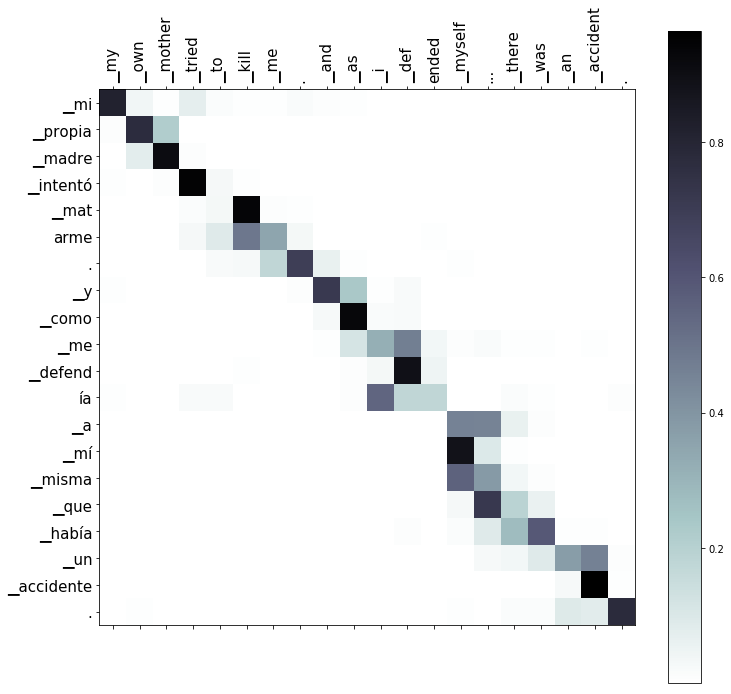

In [232]:
show_attention(input_pieces, pred_pieces, sent_attention_weights)

In [114]:
def strictly_increasing(L):
    return all(x<=y for x, y in zip(L, L[1:]))

strictly_increasing([1,2,2,2,2,2,2,3,5,4])

False

In [201]:
severe_problematic

117

In [217]:
#BATCH PROCESS INPUT SEGMENTS->OUTPUT SEGMENTS
all_input_tokens = []
all_input_token_labels = []
all_input_piece_labels = []
all_pred_piece_labels = []
all_pred_tokens = []
all_pred_token_labels = []
all_input_phrase_structure = []
all_pred_phrase_structure = []

MIN_SEGMENT_PAUSE_INTERVAL = 0.5

severe_problematic= 0

for segment_no, (input_pieces, pred_pieces, input_proscript, sent_attention_binary, sent_attention_weights) in enumerate(zip(all_input_pieces, all_pred_pieces, all_proscript, all_attention_binary, all_attention_weights)):
    try:
        input_tokens, input_token_labels, input_phrase_structure = get_input_structure(input_proscript, MIN_SEGMENT_PAUSE_INTERVAL)
        input_piece_labels = token_to_piece_labels(input_pieces, input_tokens, input_token_labels)
        pred_piece_labels = map_piece_labels_naive(pred_pieces, sent_attention_binary)
        pred_tokens, pred_token_labels = piece_to_token(pred_pieces, pred_piece_labels)
        pred_phrase_structure = get_output_phrase_structure(pred_tokens, pred_token_labels, input_phrase_structure)
    except:
        input_tokens, input_token_labels, input_piece_labels, pred_piece_labels, pred_tokens, pred_token_labels = None, None, None, None, None, None
        print("Somethings wrong processing %i"%segment_no)
        severe_problematic += 1
        
    all_input_tokens.append(input_tokens)
    all_input_token_labels.append(input_token_labels)
    all_input_piece_labels.append(input_piece_labels)
    all_input_phrase_structure.append(input_phrase_structure)
    
    all_pred_piece_labels.append(pred_piece_labels)
    all_pred_tokens.append(pred_tokens)
    all_pred_token_labels.append(pred_token_labels)
    all_pred_phrase_structure.append(pred_phrase_structure)

Somethings wrong processing 5
Somethings wrong processing 7
Somethings wrong processing 1185
Somethings wrong processing 1759
Somethings wrong processing 2174
Somethings wrong processing 2613
Somethings wrong processing 2707
Somethings wrong processing 2886
Somethings wrong processing 3018
Somethings wrong processing 3617
Somethings wrong processing 3665
Somethings wrong processing 4079
Somethings wrong processing 4643
Somethings wrong processing 4962
Somethings wrong processing 5081
Somethings wrong processing 5167
Somethings wrong processing 5206
Somethings wrong processing 5255
Somethings wrong processing 5320
Somethings wrong processing 5337
Somethings wrong processing 5358
Somethings wrong processing 5710
Somethings wrong processing 6154
Somethings wrong processing 6347
Somethings wrong processing 6927


In [249]:
#STUDY PARTICULAR DATA SAMPLE
WORKING_SENTENCE_NO = 645

input_pieces = all_input_pieces[WORKING_SENTENCE_NO]
pred_pieces = all_pred_pieces[WORKING_SENTENCE_NO]
input_proscript = all_proscript[WORKING_SENTENCE_NO]
sent_attention_binary = all_attention_binary[WORKING_SENTENCE_NO]
sent_attention_weights = all_attention_weights[WORKING_SENTENCE_NO]

# 1. read from processed batch
# input_tokens = all_input_tokens[WORKING_SENTENCE_NO]
# input_token_labels = all_input_token_labels[WORKING_SENTENCE_NO]
# input_piece_labels = all_input_piece_labels[WORKING_SENTENCE_NO]
# input_phrase_structure = all_input_phrase_structure[WORKING_SENTENCE_NO]

# pred_tokens = all_pred_tokens[WORKING_SENTENCE_NO]
# pred_piece_labels = all_pred_piece_labels[WORKING_SENTENCE_NO]
# pred_token_labels = all_pred_token_labels[WORKING_SENTENCE_NO]
# pred_phrase_structure = all_pred_phrase_structure[WORKING_SENTENCE_NO]

# 2. process your own
input_tokens, input_token_labels, input_phrase_structure = get_input_structure(input_proscript, min_segment_pause_interval=0.0)
input_piece_labels = token_to_piece_labels(input_pieces, input_tokens, input_token_labels)
pred_piece_labels = map_piece_labels_naive(pred_pieces, sent_attention_binary) 
pred_tokens, pred_token_labels = piece_to_token(pred_pieces, pred_piece_labels)
pred_phrase_structure = get_output_phrase_structure(pred_tokens, pred_token_labels, input_phrase_structure)

input_segments_from_tokens = [' '.join(p.tokens) for p in input_phrase_structure]

print("Input segments (from proscript tokens)")
print(input_segments_from_tokens)


pred_segment_pieces = [[] for i in range(max(pred_piece_labels) + 1)]
for t,i in zip(pred_pieces, pred_piece_labels):
    pred_segment_pieces[i].append(t)

pred_segments_from_pieces = [' '.join(segment_pieces) for segment_pieces in pred_segment_pieces]
    
print('\nSegmented output pieces')
print(pred_segments_from_pieces)


pred_segment_tokens = [[] for i in range(max(pred_token_labels) + 1)]
for t,i in zip(pred_tokens, pred_token_labels):
    pred_segment_tokens[i].append(t)

pred_segments_from_tokens = [' '.join(segment_tokens) for segment_tokens in pred_segment_tokens]
    
print("\nSegmented output tokens")
print(pred_segments_from_tokens)

#SHOW matched input and prediction segments
print("\nMatched input and pred segments")
full_input = ' '.join(input_segments_from_tokens)
full_translation = ' '.join(pred_segments_from_tokens)
print(full_input)
print(full_translation)
print()

for input_seg, pred_seg in zip(input_segments_from_tokens, pred_segments_from_tokens):
    print(">" + input_seg)
    print(">" + pred_seg)
    print()
    
#output files for synthesis
#1. plain translation string
file_prefix = "samples/s2_10_0223/translation"
with open (file_prefix + '.txt', 'w') as f_txt:
    f_txt.write(full_translation)
    
#2. phrase structure
phrase_output_file = "samples/s2_10_0223/output_phrase_structure.txt"
with open(phrase_output_file, 'w') as f:
    for st in pred_phrase_structure:
        f.write("%f\t%f\t%f\t%s\n"%(st.start_time, st.end_time, st.pause_after, st.tokens))

Input segments (from proscript tokens)
['my own mother tried', 'to', 'kill me', 'and as i defended myself', 'there was an accident']

Segmented output pieces
['▁mi ▁propia ▁madre ▁intentó', '', '▁mat arme .', '▁y ▁como ▁me ▁defend ía ▁a ▁mí ▁misma ▁que', '▁había ▁un ▁accidente .']

Segmented output tokens
['mi propia madre intentó', '', 'matarme.', 'y como me defendía a mí misma que', 'había un accidente.']

Matched input and pred segments
my own mother tried to kill me and as i defended myself there was an accident
mi propia madre intentó  matarme. y como me defendía a mí misma que había un accidente.

>my own mother tried
>mi propia madre intentó

>to
>

>kill me
>matarme.

>and as i defended myself
>y como me defendía a mí misma que

>there was an accident
>había un accidente.



In [231]:
phrase_output_file = "samples/s2_10_0223/output_phrase_structure.txt"
with open(phrase_output_file, 'w') as f:
    for st in pred_phrase_structure:
        f.write("%f\t%f\t%f\t%s\n"%(st.start_time, st.end_time, st.pause_after, st.tokens))

In [127]:
['i urge', 'each and every one of you...', 'to take up this cause,', 'spread the word...']


[1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [224]:
#GO SAMPLE BY SAMPLE
start_from = 500
problem_count = 0
for sent_no in range(start_from, len(all_input_pieces)):
    input_pieces = all_input_pieces[sent_no]
    pred_pieces = all_pred_pieces[sent_no]
    input_proscript = all_proscript[sent_no]
    sent_attention_binary = all_attention_binary[sent_no]
    sent_attention_weights = all_attention_weights[sent_no]
    proscript_path = all_proscript_path[sent_no]

    # 1. read from processed batch
    input_tokens = all_input_tokens[sent_no]
    input_token_labels = all_input_token_labels[sent_no]
    input_piece_labels = all_input_piece_labels[sent_no]
    input_phrase_structure = all_input_phrase_structure[sent_no]
    pred_tokens = all_pred_tokens[sent_no]
    pred_piece_labels = all_pred_piece_labels[sent_no]
    pred_token_labels = all_pred_token_labels[sent_no]
    pred_phrase_structure = all_pred_phrase_structure[sent_no]
    
    if pred_token_labels == None:
        print("SAMPLE %i problematic"%sent_no)
        continue
    
    
#     input_segment_tokens = [[] for i in range(max(input_token_labels) + 1)]
#     for t,i in zip(input_tokens, input_token_labels):
#         input_segment_tokens[i].append(t)

#     input_segments_from_tokens = [' '.join(segment_tokens) for segment_tokens in input_segment_tokens]
    input_segments_from_tokens = [' '.join(p.tokens) for p in input_phrase_structure]
    
#     pred_segment_tokens = [[] for i in range(max(pred_token_labels) + 1)]
#     for t,i in zip(pred_tokens, pred_token_labels):
#         pred_segment_tokens[i].append(t)

#     pred_segments_from_tokens = [' '.join(segment_tokens) for segment_tokens in pred_segment_tokens]
    
    pred_segments_from_tokens = [' '.join(p.tokens) for p in pred_phrase_structure]
    
    #SHOW matched input and prediction segments if there's any segmentation
    if len(input_segments_from_tokens) > 2:
        full_input = ' '.join(input_segments_from_tokens)
        full_translation = ' '.join(pred_segments_from_tokens)
        
        print("SAMPLE INDEX %i (%s)"%(sent_no, os.path.basename(proscript_path)))
        print(full_input)
        print(full_translation)
        print()
        output_segs_reconstructed = ''
        input_segs_reconstructed = ''
        for input_seg, pred_seg in zip(input_segments_from_tokens, pred_segments_from_tokens):
            print(">" + input_seg)
            print("<" + pred_seg)
            print()
            output_segs_reconstructed += pred_seg + ' '
            input_segs_reconstructed += input_seg + ' '
        
        if not strictly_increasing(pred_token_labels):
            print("SAMPLE INDEX %i (%s)"%(sent_no, os.path.basename(proscript_path)))
            print("kopuk token labels")
            problem_count += 1
        
        if not full_translation == output_segs_reconstructed.strip():
            print('WARNING: output seg not fully covered')
        
        if not full_input == input_segs_reconstructed.strip():
            print('WARNING: input seg not fully covered')
              

        inp = input("...")
        if inp == 'x' or inp == 'X':
            break
    

SAMPLE INDEX 645 (heroes_s2_10_eng_aligned_eng0223.csv)
my own mother tried to kill me and as i defended myself there was an accident
mi propia madre intentó matarme. y como me defendía a mí misma que había un accidente.

>my own mother tried to kill me
<mi propia madre intentó matarme.

>and as i defended myself
<y como me defendía a mí misma que

>there was an accident
<había un accidente.

...
SAMPLE INDEX 703 (heroes_s2_10_eng_aligned_eng0281.csv)
about everything about me about alejandro
sobre todo. sobre mí. sobre el punto de vista.

>about everything
<sobre todo.

>about me
<sobre mí.

>about alejandro
<sobre el punto de vista.

...
SAMPLE INDEX 732 (heroes_s2_10_eng_aligned_eng0310.csv)
as long as you stay out of the way anything crazy happens i need you safe
a medida que te quedas de la manera. algo loco ocurre, necesito seguro.

>as long as you stay out of the way
<a medida que te quedas de la manera.

>anything crazy happens
<algo loco ocurre,

>i need you safe
<necesito seg

In [211]:
all_pred_token_labels[6]

[0, 0, 0]